# Notebook 4: The Kuramoto Connection

**Duration**: 2 hours  
**Prerequisites**: Notebook 1

This notebook explores the connection between attention dynamics and the **Kuramoto model**—a classical model of coupled oscillators that synchronize. This connection provides powerful analytical tools and intuition.

---

## Learning Objectives

By the end of this notebook, you should be able to:

- [ ] Recognize the Kuramoto model as the β=0 limit of USA
- [ ] Understand synchronization on the circle (d=2)
- [ ] See how higher dimensions change the dynamics
- [ ] Connect to synchronization literature for analytical tools

---

## Connection to Your Work

This provides intuition and connects to a well-studied mathematical field. The synchronization literature gives tools to understand attention dynamics that have been developed over decades.

In [1]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display

# Visualization setup
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# Import our utilities
from utils import (
    kuramoto_velocity,
    kuramoto_velocity_general,
    simulate_kuramoto,
    simulate_sa,
    random_sphere_points,
    project_to_sphere,
    pairwise_similarity_dist,
    compute_cluster_metric
)

np.random.seed(42)
print("Imports loaded successfully!")

Imports loaded successfully!


---

## 1. The Kuramoto Model

### Historical Context

The **Kuramoto model** (1975) describes coupled oscillators that tend to synchronize:
- Fireflies flashing in unison
- Neurons firing together
- Pacemaker cells in the heart

### The Equation

For $n$ oscillators with phases $\theta_i \in [0, 2\pi)$:

$$\dot{\theta}_i = -\frac{1}{n} \sum_{j=1}^n \sin(\theta_i - \theta_j)$$

Each oscillator is pulled toward the others—they want to align!

### Connection to Attention

This is exactly the **USA dynamics on the circle** (d=2) with **β=0**:
- $\theta_i$ = angle on the circle
- $\sin(\theta_i - \theta_j)$ = tangential component of attraction

In [2]:
# Demonstrate the basic Kuramoto model

n = 8  # Number of oscillators
np.random.seed(42)

# Random initial phases
theta0 = np.random.uniform(0, 2*np.pi, n)

# Simulate
t_end = 10.0
times, theta_traj = simulate_kuramoto(theta0, (0, t_end), n_steps=200, beta=0)

print(f"Initial phases: {theta0}")
print(f"Final phases: {theta_traj[-1]}")
print(f"\nPhases wrap around: values are mod 2π")

Initial phases: [2.35330497 5.97351416 4.59925358 3.76148219 0.98029403 0.98014248
 0.3649501  5.44234523]
Final phases: [-0.08359964  6.19848342  6.19809538  6.19733482 -0.08441534 -0.08441538
 -0.08456129  6.19836477]

Phases wrap around: values are mod 2π


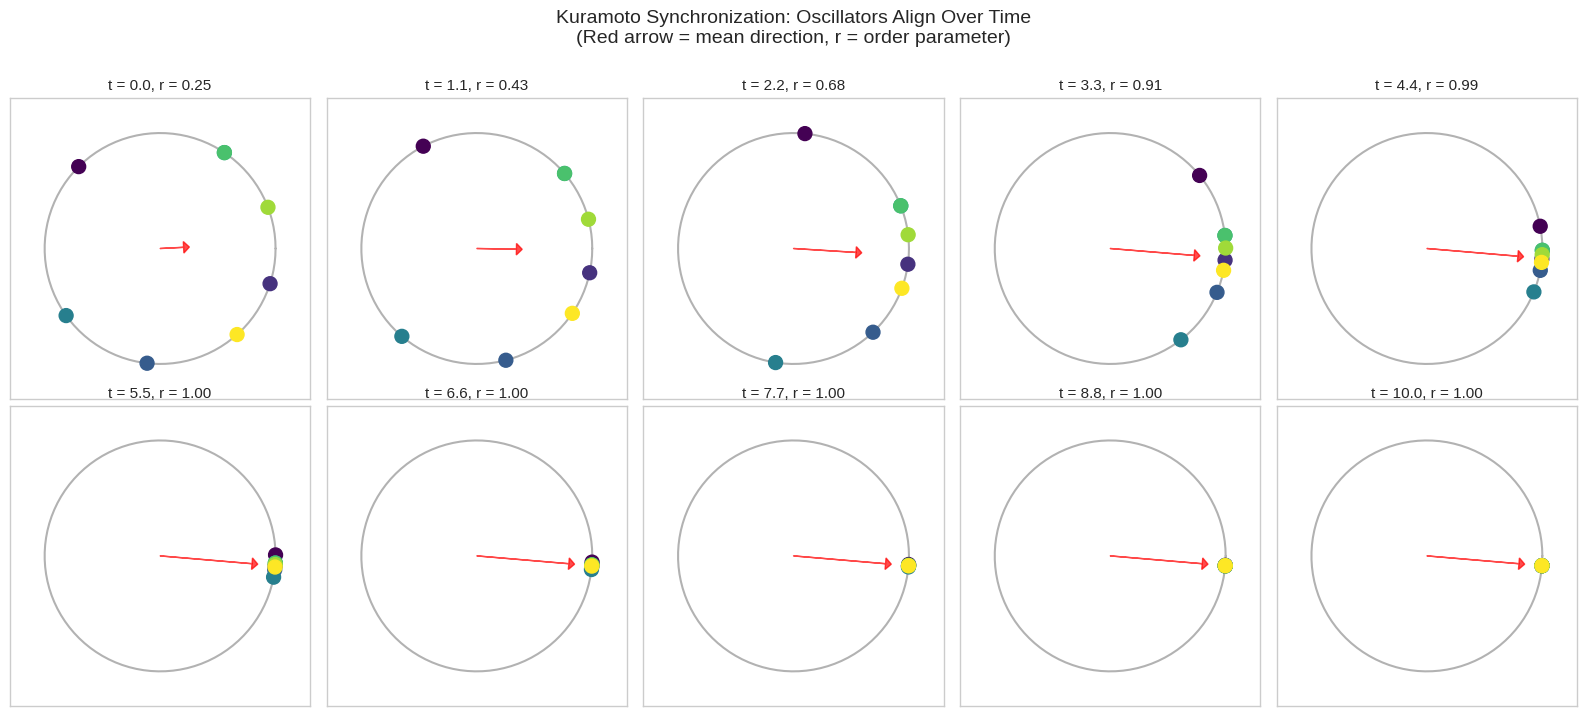

The order parameter r measures synchronization:
  r ≈ 0: phases uniformly spread (desynchronized)
  r ≈ 1: phases all aligned (synchronized)


In [3]:
# Visualize oscillator phases on the circle over time

def phases_to_circle(theta):
    """Convert phases to (x, y) on unit circle."""
    return np.cos(theta), np.sin(theta)

# Create animation frames
n_frames = 10
frame_indices = np.linspace(0, len(times)-1, n_frames, dtype=int)

fig, axes = plt.subplots(2, 5, figsize=(16, 7))
axes = axes.flatten()

for idx, frame_idx in enumerate(frame_indices):
    theta = theta_traj[frame_idx]
    x, y = phases_to_circle(theta)
    
    ax = axes[idx]
    
    # Draw unit circle
    circle_theta = np.linspace(0, 2*np.pi, 100)
    ax.plot(np.cos(circle_theta), np.sin(circle_theta), 'k-', alpha=0.3)
    
    # Draw oscillators
    colors = plt.cm.viridis(np.linspace(0, 1, n))
    ax.scatter(x, y, c=colors, s=100, zorder=5)
    
    # Draw mean direction (order parameter)
    mean_x, mean_y = np.mean(x), np.mean(y)
    r = np.sqrt(mean_x**2 + mean_y**2)  # Order parameter magnitude
    ax.arrow(0, 0, mean_x*0.8, mean_y*0.8, head_width=0.1, head_length=0.05, 
             fc='red', ec='red', alpha=0.7)
    
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3, 1.3)
    ax.set_aspect('equal')
    ax.set_title(f't = {times[frame_idx]:.1f}, r = {r:.2f}', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle('Kuramoto Synchronization: Oscillators Align Over Time\n(Red arrow = mean direction, r = order parameter)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("The order parameter r measures synchronization:")
print("  r ≈ 0: phases uniformly spread (desynchronized)")
print("  r ≈ 1: phases all aligned (synchronized)")

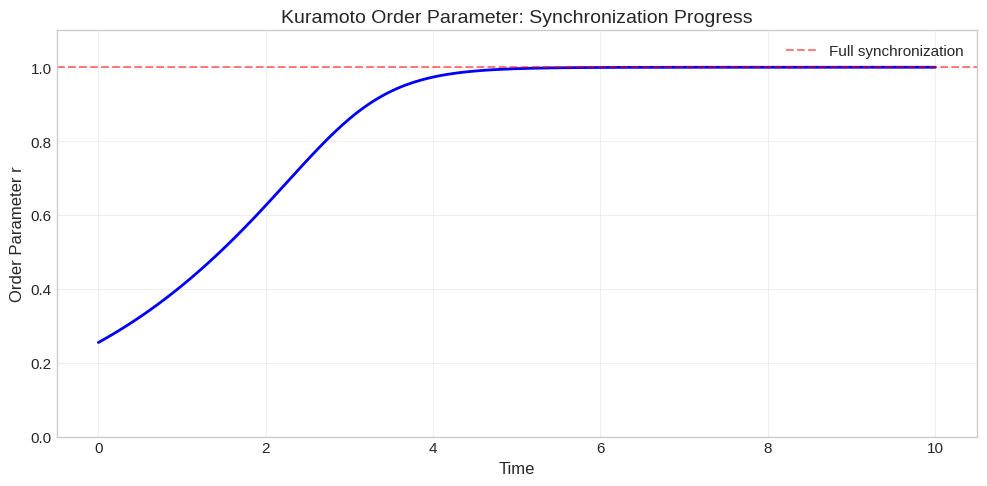

Initial order parameter: 0.2547
Final order parameter: 1.0000


In [4]:
# Track the order parameter over time

def compute_order_parameter(theta):
    """Compute Kuramoto order parameter r."""
    z = np.mean(np.exp(1j * theta))  # Complex mean
    return np.abs(z)

order_params = [compute_order_parameter(theta_traj[i]) for i in range(len(times))]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(times, order_params, 'b-', linewidth=2)
ax.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Full synchronization')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Order Parameter r', fontsize=12)
ax.set_title('Kuramoto Order Parameter: Synchronization Progress', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

print(f"Initial order parameter: {order_params[0]:.4f}")
print(f"Final order parameter: {order_params[-1]:.4f}")

---

## 2. Generalized Kuramoto (β > 0)

### Extending to Temperature

The paper's Equation (4) generalizes Kuramoto to arbitrary β:

$$\dot{\theta}_i = -\frac{1}{n} \sum_{j=1}^n \exp(\beta \cos(\theta_i - \theta_j)) \sin(\theta_i - \theta_j)$$

### Effect of β

| β | Effect |
|---|--------|
| β = 0 | Classical Kuramoto (uniform interaction) |
| β > 0 | Stronger interaction when aligned (sharper attraction) |
| β → ∞ | Only nearest neighbor interacts (winner-take-all) |

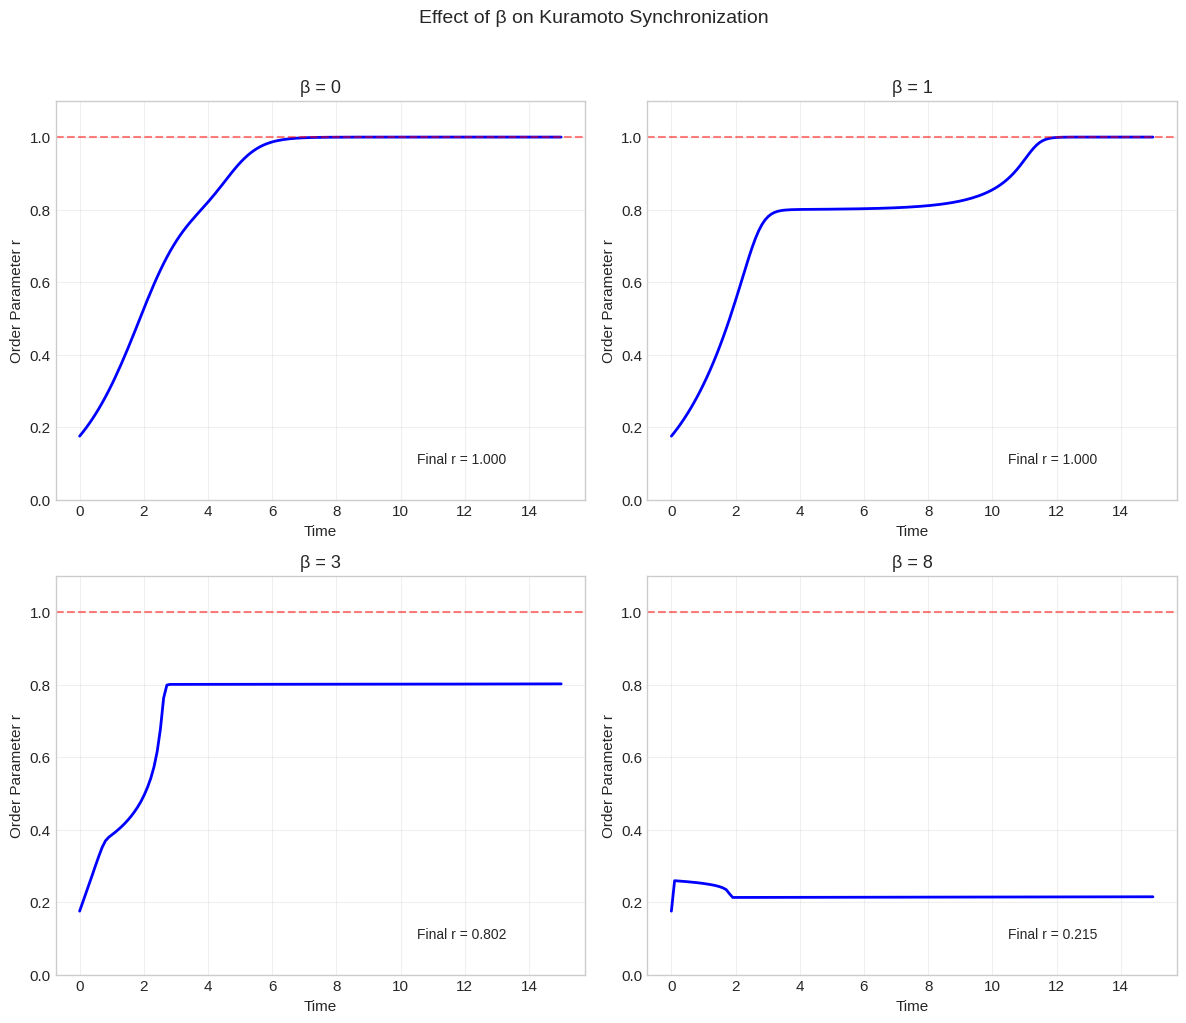

Observation: Higher β leads to faster synchronization.
This matches our understanding from the sphere dynamics!


In [5]:
# Compare Kuramoto dynamics for different β values

betas = [0, 1, 3, 8]
n = 10
t_end = 15.0

# Same initial condition for all
np.random.seed(42)
theta0 = np.random.uniform(0, 2*np.pi, n)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, beta in enumerate(betas):
    times, theta_traj = simulate_kuramoto(theta0, (0, t_end), n_steps=150, beta=beta)
    
    # Compute order parameter over time
    order = [compute_order_parameter(theta_traj[i]) for i in range(len(times))]
    
    ax = axes[idx]
    ax.plot(times, order, 'b-', linewidth=2)
    ax.axhline(y=1.0, color='r', linestyle='--', alpha=0.5)
    ax.set_xlabel('Time', fontsize=11)
    ax.set_ylabel('Order Parameter r', fontsize=11)
    ax.set_title(f'β = {beta}', fontsize=13)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.1)
    
    # Add final value annotation
    ax.text(t_end*0.7, 0.1, f'Final r = {order[-1]:.3f}', fontsize=10)

plt.suptitle('Effect of β on Kuramoto Synchronization', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Observation: Higher β leads to faster synchronization.")
print("This matches our understanding from the sphere dynamics!")

---

## 3. From Circle to Sphere

### The Kuramoto-Sphere Connection

| Setting | Space | Equation |
|---------|-------|----------|
| Kuramoto | Circle $S^1$ | $\dot{\theta}_i = -\frac{1}{n} \sum_j \sin(\theta_i - \theta_j)$ |
| USA (d=2) | Circle $S^1$ | Same! (with β term) |
| USA (d≥3) | Sphere $S^{d-1}$ | Generalization to higher dimensions |

### What Changes in Higher Dimensions?

On the circle:
- Only two directions to move (clockwise/counterclockwise)
- Dynamics are essentially 1D

On the sphere:
- Many directions available
- Richer geometry, more complex dynamics
- But same fundamental behavior: **synchronization/clustering**

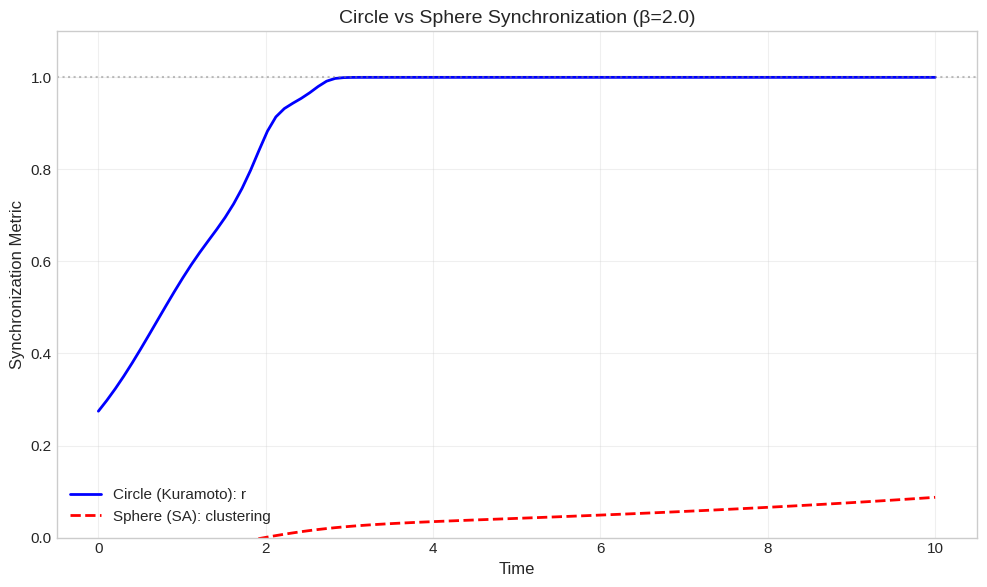

Both dynamics show synchronization/clustering!
The sphere has more degrees of freedom but converges similarly.


In [6]:
# Compare circle (d=2) vs sphere (d=3) dynamics

n = 15
beta = 2.0
t_end = 10.0

# Circle: angles
np.random.seed(42)
theta0 = np.random.uniform(0, 2*np.pi, n)
times_circle, theta_traj = simulate_kuramoto(theta0, (0, t_end), n_steps=100, beta=beta)

# Sphere: 3D points
X0_sphere = random_sphere_points(n, 3, seed=42)
times_sphere, X_traj = simulate_sa(X0_sphere, beta, (0, t_end), n_steps=100)

# Compute order parameters / clustering metrics
order_circle = [compute_order_parameter(theta_traj[i]) for i in range(len(times_circle))]
cluster_sphere = [compute_cluster_metric(X_traj[i]) for i in range(len(times_sphere))]

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(times_circle, order_circle, 'b-', linewidth=2, label='Circle (Kuramoto): r')
ax.plot(times_sphere, cluster_sphere, 'r--', linewidth=2, label='Sphere (SA): clustering')
ax.axhline(y=1.0, color='gray', linestyle=':', alpha=0.5)

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Synchronization Metric', fontsize=12)
ax.set_title(f'Circle vs Sphere Synchronization (β={beta})', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

print("Both dynamics show synchronization/clustering!")
print("The sphere has more degrees of freedom but converges similarly.")

---

## 4. Phase Portraits

### Visualizing Dynamics on the Torus

For n=2 oscillators, we can visualize the full dynamics:
- State space is a torus (θ₁, θ₂) ∈ [0, 2π)²
- Flow shows how the system evolves
- Fixed points = equilibria

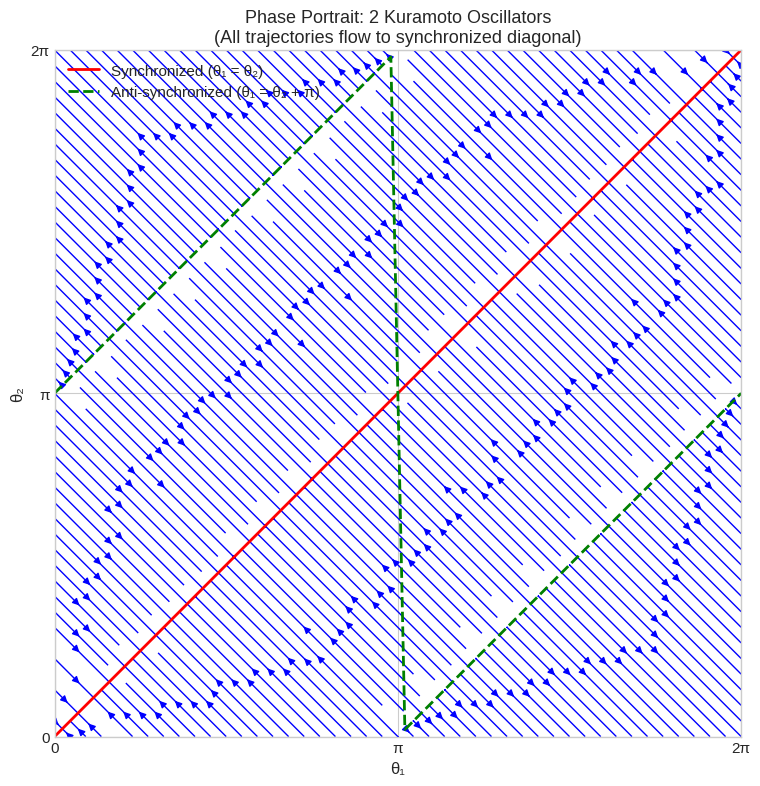

Key insight: All trajectories flow toward the diagonal (θ₁ = θ₂).
The anti-diagonal (θ₁ = θ₂ + π) is an unstable equilibrium.


In [7]:
# Phase portrait for n=2 Kuramoto model

# Create grid
n_grid = 20
theta1 = np.linspace(0, 2*np.pi, n_grid)
theta2 = np.linspace(0, 2*np.pi, n_grid)
T1, T2 = np.meshgrid(theta1, theta2)

# Compute velocities at each point
def kuramoto_2d_velocity(t1, t2, beta=0):
    """Velocity for 2-oscillator Kuramoto."""
    theta = np.array([t1, t2])
    if beta == 0:
        v = kuramoto_velocity(theta)
    else:
        v = kuramoto_velocity_general(theta, beta)
    return v[0], v[1]

# Compute velocity field
V1 = np.zeros_like(T1)
V2 = np.zeros_like(T2)

for i in range(n_grid):
    for j in range(n_grid):
        v1, v2 = kuramoto_2d_velocity(T1[i, j], T2[i, j], beta=0)
        V1[i, j] = v1
        V2[i, j] = v2

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Streamplot
ax.streamplot(theta1, theta2, V1, V2, density=1.5, color='blue', linewidth=1)

# Mark fixed points (synchronized states: θ1 = θ2)
sync_line = np.linspace(0, 2*np.pi, 50)
ax.plot(sync_line, sync_line, 'r-', linewidth=2, label='Synchronized (θ₁ = θ₂)')
ax.plot(sync_line, (sync_line + np.pi) % (2*np.pi), 'g--', linewidth=2, 
        label='Anti-synchronized (θ₁ = θ₂ + π)')

ax.set_xlabel('θ₁', fontsize=12)
ax.set_ylabel('θ₂', fontsize=12)
ax.set_title('Phase Portrait: 2 Kuramoto Oscillators\n(All trajectories flow to synchronized diagonal)', fontsize=13)
ax.legend()
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(0, 2*np.pi)
ax.set_aspect('equal')

# Add π markers
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels(['0', 'π', '2π'])
ax.set_yticks([0, np.pi, 2*np.pi])
ax.set_yticklabels(['0', 'π', '2π'])

plt.tight_layout()
plt.show()

print("Key insight: All trajectories flow toward the diagonal (θ₁ = θ₂).")
print("The anti-diagonal (θ₁ = θ₂ + π) is an unstable equilibrium.")

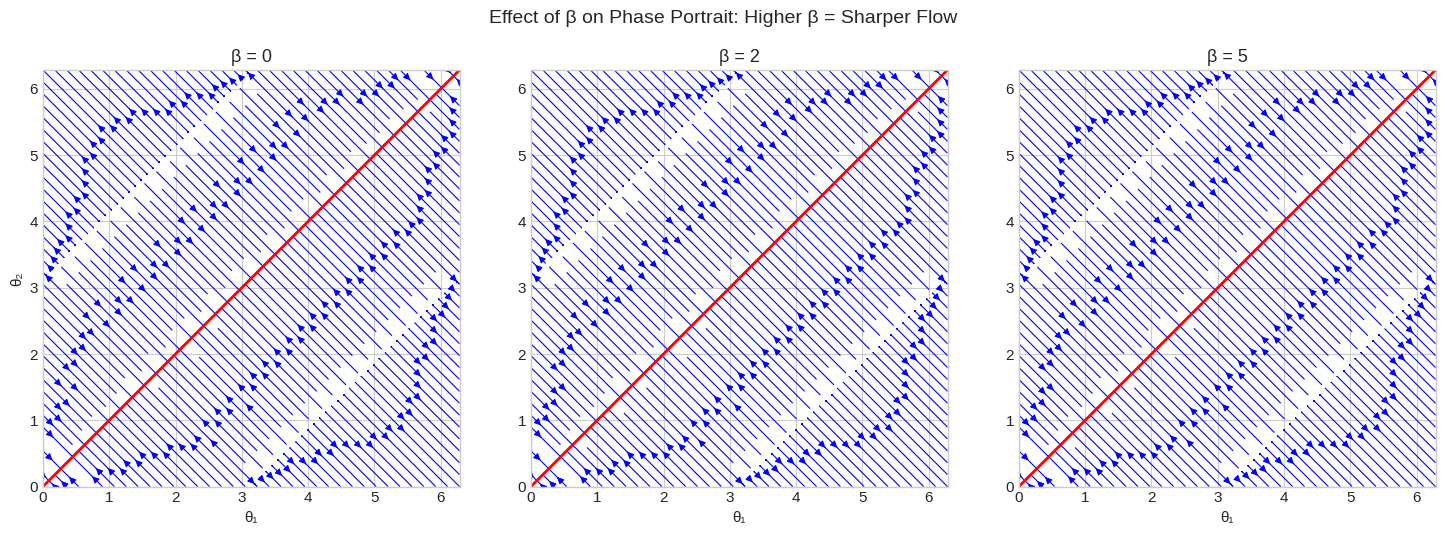

Higher β creates stronger flow toward synchronization.


In [8]:
# Compare phase portraits for different β

betas_pp = [0, 2, 5]
n_grid = 15

theta1 = np.linspace(0, 2*np.pi, n_grid)
theta2 = np.linspace(0, 2*np.pi, n_grid)
T1, T2 = np.meshgrid(theta1, theta2)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, beta in enumerate(betas_pp):
    V1 = np.zeros_like(T1)
    V2 = np.zeros_like(T2)
    
    for i in range(n_grid):
        for j in range(n_grid):
            v1, v2 = kuramoto_2d_velocity(T1[i, j], T2[i, j], beta=beta)
            V1[i, j] = v1
            V2[i, j] = v2
    
    ax = axes[idx]
    ax.streamplot(theta1, theta2, V1, V2, density=1.2, color='blue', linewidth=0.8)
    
    # Synchronized diagonal
    sync_line = np.linspace(0, 2*np.pi, 50)
    ax.plot(sync_line, sync_line, 'r-', linewidth=2)
    
    ax.set_xlabel('θ₁')
    ax.set_ylabel('θ₂' if idx == 0 else '')
    ax.set_title(f'β = {beta}', fontsize=13)
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(0, 2*np.pi)
    ax.set_aspect('equal')

plt.suptitle('Effect of β on Phase Portrait: Higher β = Sharper Flow', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Higher β creates stronger flow toward synchronization.")

---

## 5. Analytical Tools from Kuramoto Literature

### What We Gain

The Kuramoto model has been studied for 50 years. Key results that apply to attention:

| Result | Kuramoto Statement | Attention Translation |
|--------|-------------------|----------------------|
| Global sync | All oscillators align | All tokens cluster (Theorem 1) |
| Order parameter | Measures coherence | Mean pairwise similarity |
| Basin of attraction | Initial conditions that sync | Initial embeddings that cluster |
| Stability analysis | Which states are stable | Why only full clustering is stable |

### Mean-Field Theory

For large n, the Kuramoto model admits a mean-field description:
- Individual oscillators → probability distribution on the circle
- This is exactly how the paper analyzes attention dynamics!

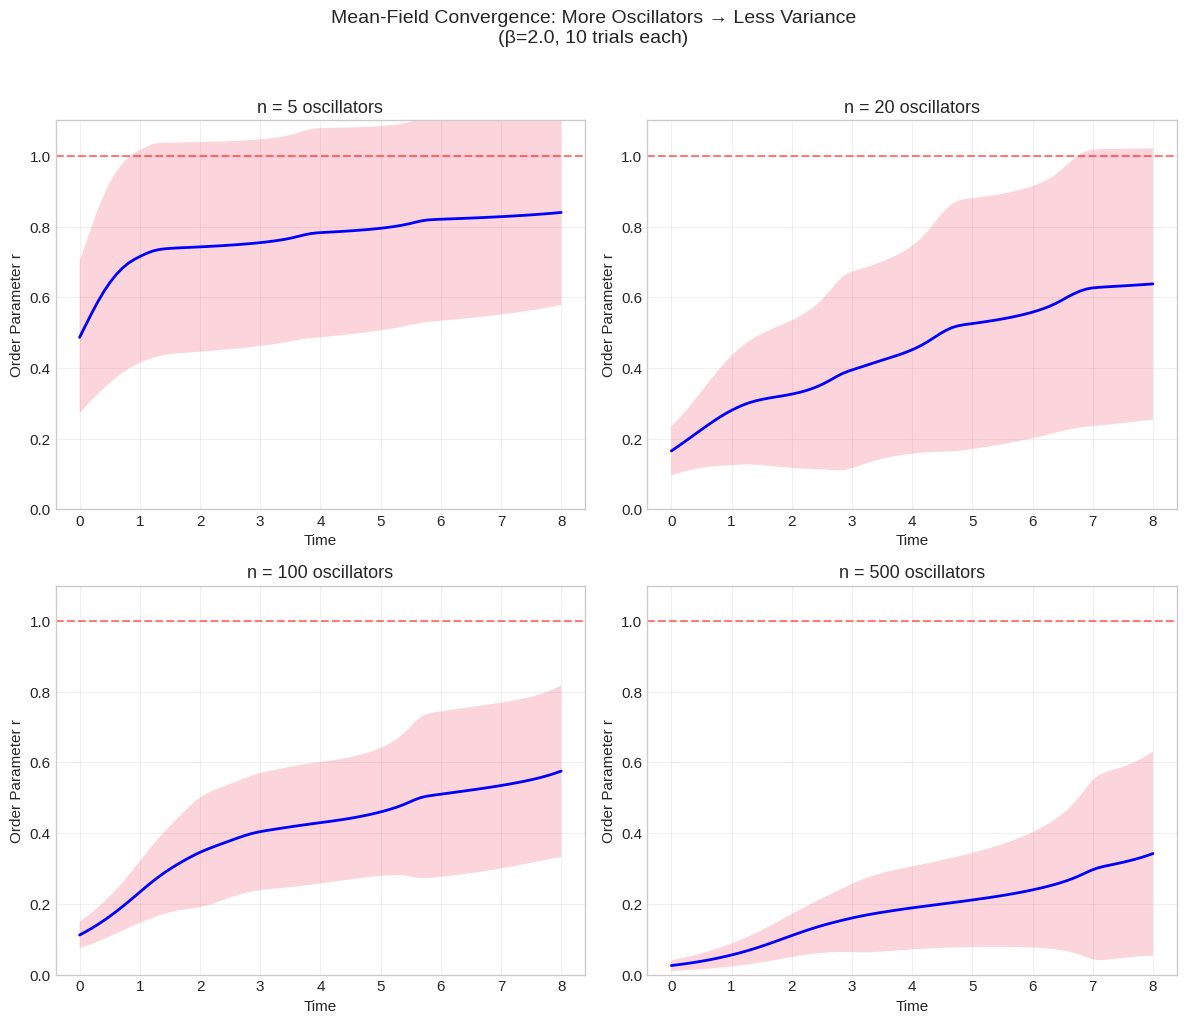

As n → ∞, the dynamics become deterministic (mean-field limit).
This is the regime where the paper's theorems are most precise.


In [9]:
# Demonstrate mean-field behavior with many oscillators

n_values = [5, 20, 100, 500]
beta = 2.0
t_end = 8.0

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, n in enumerate(n_values):
    # Run multiple trials
    n_trials = 10
    all_orders = []
    
    for trial in range(n_trials):
        theta0 = np.random.uniform(0, 2*np.pi, n)
        times, theta_traj = simulate_kuramoto(theta0, (0, t_end), n_steps=80, beta=beta)
        orders = [compute_order_parameter(theta_traj[i]) for i in range(len(times))]
        all_orders.append(orders)
    
    all_orders = np.array(all_orders)
    mean_order = np.mean(all_orders, axis=0)
    std_order = np.std(all_orders, axis=0)
    
    ax = axes[idx]
    ax.fill_between(times, mean_order - std_order, mean_order + std_order, alpha=0.3)
    ax.plot(times, mean_order, 'b-', linewidth=2)
    ax.axhline(y=1.0, color='r', linestyle='--', alpha=0.5)
    ax.set_xlabel('Time', fontsize=11)
    ax.set_ylabel('Order Parameter r', fontsize=11)
    ax.set_title(f'n = {n} oscillators', fontsize=13)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.1)

plt.suptitle(f'Mean-Field Convergence: More Oscillators → Less Variance\n(β={beta}, {n_trials} trials each)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("As n → ∞, the dynamics become deterministic (mean-field limit).")
print("This is the regime where the paper's theorems are most precise.")

---

## 6. Interactive Exploration

In [10]:
# Interactive Kuramoto exploration

def explore_kuramoto(n, beta, t_end):
    """Interactive Kuramoto exploration."""
    
    np.random.seed(42)
    theta0 = np.random.uniform(0, 2*np.pi, n)
    times, theta_traj = simulate_kuramoto(theta0, (0, t_end), n_steps=100, beta=beta)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Order parameter
    orders = [compute_order_parameter(theta_traj[i]) for i in range(len(times))]
    axes[0].plot(times, orders, 'b-', linewidth=2)
    axes[0].axhline(y=1.0, color='r', linestyle='--', alpha=0.5)
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Order Parameter r')
    axes[0].set_title('Synchronization Progress')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, 1.1)
    
    # Phase distribution at different times
    for t_frac, color in [(0, 'blue'), (0.5, 'green'), (1.0, 'red')]:
        t_idx = int(t_frac * (len(times) - 1))
        theta = theta_traj[t_idx] % (2*np.pi)
        axes[1].hist(theta, bins=20, alpha=0.5, density=True, 
                     label=f't={times[t_idx]:.1f}', color=color)
    axes[1].set_xlabel('Phase θ')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Phase Distribution')
    axes[1].legend()
    axes[1].set_xlim(0, 2*np.pi)
    axes[1].grid(True, alpha=0.3)
    
    # Final state on circle
    theta_final = theta_traj[-1]
    x, y = np.cos(theta_final), np.sin(theta_final)
    
    circle_t = np.linspace(0, 2*np.pi, 100)
    axes[2].plot(np.cos(circle_t), np.sin(circle_t), 'k-', alpha=0.3)
    axes[2].scatter(x, y, c=np.arange(n), cmap='viridis', s=50)
    
    mean_x, mean_y = np.mean(x), np.mean(y)
    axes[2].arrow(0, 0, mean_x*0.8, mean_y*0.8, head_width=0.1, 
                  head_length=0.05, fc='red', ec='red')
    
    axes[2].set_xlim(-1.3, 1.3)
    axes[2].set_ylim(-1.3, 1.3)
    axes[2].set_aspect('equal')
    axes[2].set_title(f'Final State (r={orders[-1]:.3f})')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

widgets.interact(
    explore_kuramoto,
    n=widgets.IntSlider(value=10, min=3, max=50, step=1, description='Oscillators:'),
    beta=widgets.FloatSlider(value=0.0, min=0.0, max=10.0, step=0.5, description='β:'),
    t_end=widgets.FloatSlider(value=10.0, min=2.0, max=30.0, step=2.0, description='Time:')
)

interactive(children=(IntSlider(value=10, description='Oscillators:', max=50, min=3), FloatSlider(value=0.0, d…

<function __main__.explore_kuramoto(n, beta, t_end)>

---

## Summary: The Kuramoto Connection

### Key Insights

| Kuramoto Concept | Attention Translation |
|-----------------|----------------------|
| Oscillators | Tokens |
| Phase θ | Position on sphere |
| Synchronization | Clustering |
| Order parameter r | Mean pairwise similarity |
| β=0 (classical) | Uniform interaction |
| β>0 | Sharper attention |

### What We Gain

1. **Analytical tools**: 50 years of Kuramoto literature applies
2. **Physical intuition**: Synchronization is a well-understood phenomenon
3. **Mean-field theory**: Rigorous framework for large n
4. **Phase portraits**: Visual understanding of dynamics

### Limitations

- The Kuramoto model is on the circle (d=2)
- Real transformers use d=384-1024
- But the qualitative behavior transfers!

---

## Next: Notebook 5 - Normalization Schemes

We'll analyze how Pre-LN vs Post-LN normalization affects the clustering dynamics and contraction rates.